In [ ]:
import pandas as pd
import os
import sys
import json
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import statistics

In [ ]:
os.makedirs('./mem', exist_ok=True)

In [ ]:
def gen_plot(lib_name, ylims=None, height_ratios=None, bbox_to_anchor_y=None):
  assert (ylims is None) == (height_ratios is None) == (bbox_to_anchor_y is None)
  max_sf = 20
  directory = Path(f'./output-stats/stats-pandas-default')
  files = [f.name for f in directory.iterdir() if f.is_file()]
  files.remove('.version')
  fnames = files

  labels = ['default', '5-sec', '10-sec', '20-sec']
    
  columns = ['Maximum', 'Geomean']
  x = np.arange(len(labels))
    
  def get_dir_mem(dir_, nb_set=None):
    nb_mem = []
    used_nbs = []
    for fname in fnames:
      if not os.path.exists(os.path.join(dir_, fname)) or (nb_set is not None and fname not in nb_set):
        continue
      with open(os.path.join(dir_, fname), 'r') as fp:
        nb = json.load(fp)

      nb_mem.append(nb['max-mem-in-mb'] + nb['max-disk-in-mb'])
      used_nbs.append(fname)
    ### END FOR ###

    nb_mem = pd.Series(nb_mem, index=used_nbs)
    return nb_mem
    
  #results
  max_rel = []
  avg_rel = []
  for sf in ['default', '5-sec', '10-sec', '20-sec']:
    cmp = get_dir_mem(f'./output-stats/stats-{lib_name}-{sf}')
    baseline = get_dir_mem(f'./output-stats/stats-pandas-{sf}', cmp.index)
    
    new_baseline = []
    new_cmp = []
    for i in range(len(baseline)):
      if cmp[i] > 0:
        new_baseline.append(baseline[i])
        new_cmp.append(cmp[i])
        
    rel_mem = pd.Series(new_cmp) / pd.Series(new_baseline)
    max_rel.append(max(rel_mem))
    avg_rel.append(statistics.geometric_mean(rel_mem))

  print(max_rel)
  print(avg_rel)

  #bar width
  width = 0.4

  #color scheme
  colors = {
    'max': '#A68DAD',
    'avg': '#E8C07D', 
  }

  #hatches
  hatches = ['/', 'o', '\\\\', '.', '//', 'x']
    
  def plot_on_ax(ax):
    rects1 = ax.bar(x - 1*width, max_rel, width, label='Maximum', color=colors['max'], hatch=hatches[0], alpha=0.8)
    rects2 = ax.bar(x - 0*width, avg_rel, width, label='Geomean', color=colors['avg'], hatch=hatches[1])
    #axis labels and title

    #x-axis ticks
    ax.set_xticks([(x2-width/2) for x2 in x])
    ax.set_xticklabels(labels, fontsize=12)

    #limits of the y-axis
    #   ax.set_ylim(0, ylim)
    #horizontal line at y=1 for the baseline
    #   ax.axhline(1, color='red')
    ax.axhline(1, color='grey', linestyle='--', linewidth=1.5)

    #gridlines
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='lightgrey')

    #tick parameters
    ax.tick_params(axis='both', which='major', labelsize=12)

    # annotations for each bar
    for rect in [rects1, rects2]:
      for r in rect:
        height = r.get_height()
        ypos = height
        if lib_name == 'koalas' and 0.45 <= height <= 0.46:
          ypos += 0.8
        if lib_name == 'dask' and 0.95 <= height <= 0.96:
          ypos += 0.05
        # END IF #
        ax.annotate(f'{height:.2f}',
                    xy=(r.get_x() + r.get_width() / 2, ypos),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

  #plot bars

  if lib_name == 'modin':
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(8, 4), gridspec_kw={'height_ratios': [1, 2.5]})

    rects1 = ax1.bar(x - 1*width, max_rel, width, label='Maximum', color=colors['max'], hatch=hatches[0], alpha=0.8)
    rects2 = ax1.bar(x - 0*width, avg_rel, width, label='Geomean', color=colors['avg'], hatch=hatches[1])
    
    ax2.bar(x - 1*width, max_rel, width, label='Maximum', color=colors['max'], hatch=hatches[0], alpha=0.8)
    ax2.bar(x - 0*width, avg_rel, width, label='Geomean', color=colors['avg'], hatch=hatches[1])

    # Set axis limits
    ax1.set_ylim(297, max(max_rel)+max(max_rel)*0.15)  # Focus on the high value
    ax2.set_ylim(0, 12.04)   # Focus on the smaller values

    # Hide the spines between the axes
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.set_xticks([])

    ax2.set_ylabel('Relative Memory+Disk Usage', fontsize=14)
    ax2.yaxis.set_label_coords(-0.075, 0.72)
    # legend at the top
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=6, fontsize=13, frameon=False)

    #x-axis ticks
    ax2.set_xticks([(x2-width/2) for x2 in x])
    ax2.set_xticklabels(labels, fontsize=12)

    ax2.axhline(1, color='grey', linestyle='--', linewidth=1.5)

    # gridlines
    ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='lightgrey')
    ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='lightgrey')

    # tick parameters
    ax1.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='both', labelsize=12)

    ax2.set_yticks([0, 1, 3, 6, 9, 12])


    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

    for rect in [rects1, rects2]:
      for r in rect:
        height = r.get_height()
        ypos = height
        # END IF #
        ax2.annotate(f'{height:.2f}',
                    xy=(r.get_x() + r.get_width() / 2, ypos),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)
        ax1.annotate(f'{height:.2f}',
              xy=(r.get_x() + r.get_width() / 2, ypos),
              xytext=(0, 4),
              textcoords="offset points",
              ha='center', va='bottom',
              fontsize=8)
  else:
    #subplots and set figure size
    fig, ax = None, None
    fig, ax = plt.subplots(figsize=(8, 5))
    plot_on_ax(ax)

    ax.set_ylabel('Relative Memory+Disk Usage', fontsize=14)
    # legend at the top
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.14), ncol=6, fontsize=13, frameon=False)


    ax.set_ylim(0, max(max_rel)+max(max_rel)*0.1)

    if lib_name == 'koalas':
      ax.set_yticks([0, 1, 3, 6, 9, 12, 14])


    #layout
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.3)

  #save as pdf
  plt.savefig(f"./mem/mem-{lib_name}.png", format="png", dpi=1000, bbox_inches="tight", pad_inches=0)

  #display
  plt.show()

[11.263636363636364, 10.932773109243698, 11.23015873015873, 451.9259259259259]
[5.162516430426198, 3.0946104980461757, 2.4788322916197867, 2.152299775886765]


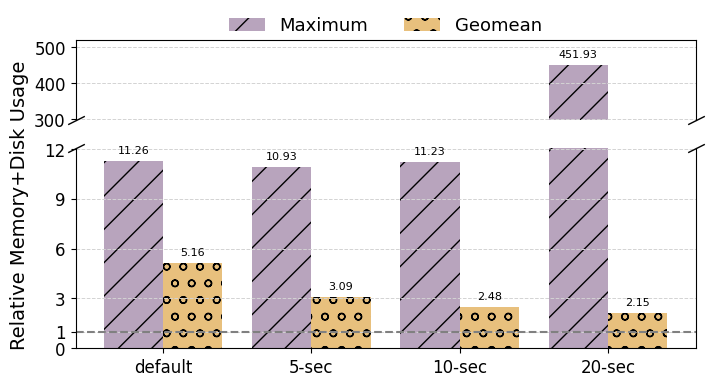

In [3]:
gen_plot('modin') #, ((0, 180), (1280, 1310)), [1, 6], 2)

[1.3888888888888888, 2.2979683972911964, 1.664092664092664, 1.16597510373444]
[1.0560201523338553, 0.9488648080999121, 0.6783112783845262, 0.428013470765262]


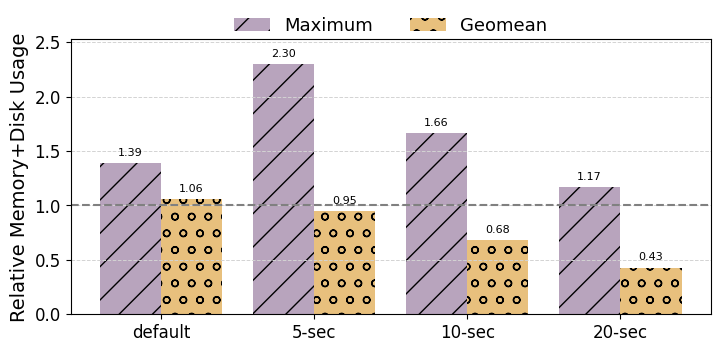

In [4]:
gen_plot('dask')

[13.772357723577235, 8.360742705570292, 5.245315161839864, 3.1193737769080236]
[7.363408235765382, 2.4545295572124566, 1.393820602913288, 0.7947540853202766]


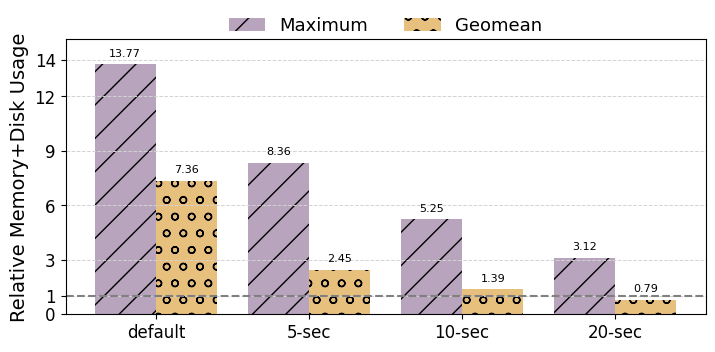

In [5]:
gen_plot('koalas')

[1.256811301715439, 1.7358916478555304, 1.8275418275418276, 1.9011065006915628]
[1.0250197083295183, 1.053574073437682, 1.0612577038820699, 1.0702471616911227]


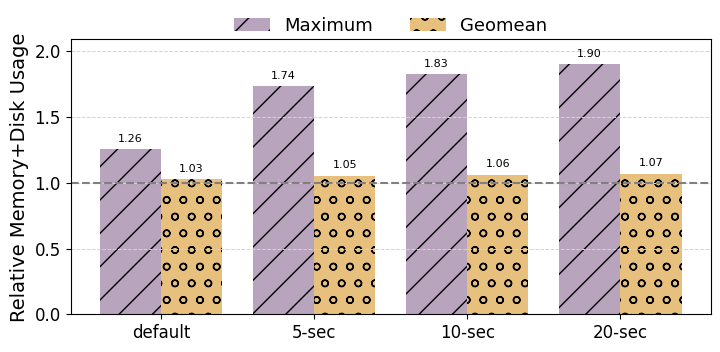

In [6]:
gen_plot('dias') # , ((0, 0.099), (0.9, 1.5)), [6, 1], 1.15)

[1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0]


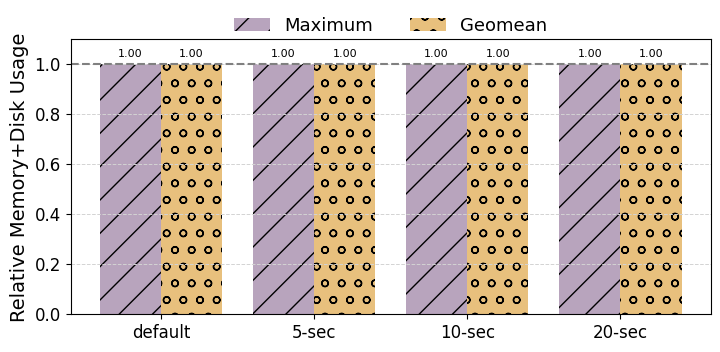

In [7]:
gen_plot('pandas')